# Chapter 1 线性回归

任何机器学习或统计学习相关教材几乎都以线性回归作为实例的第一章, 因为它与其他学科的联系紧密, 且推导简单, 易于理解. 本章介绍线性回归, 以及线性回归如何在sklearn中实现, 还介绍线性回归的一些变体.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes, fetch_california_housing
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, lasso_path
np.set_printoptions(precision=3, linewidth=np.inf)
np.random.seed(2023)

## 1.1 线性回归的基本形式

大部分机器学习算法可以分为两大类: 有监督学习与无监督学习. 对于一批样本数据 $\{X_i\}_{i=1}^{n}$, 其中每一个 $X_i$ 是一个 $m$ 维向量, 用一个数据矩阵 $X\in\mathbb{R}^{n\times m}$ 来表示样本数据. **有监督学习**指的是每一个样本数据 $X_i$ 对应一个标签 $y_i$, 通常在实际生活中, 希望用观察到的 $X_i$ 预测未观察到的 $y_i$, 因此算法希望从一系列有标签数据中学到一个能够尽可能预测标签的范式 $h(X_i)=y_i$; **无监督学习**指的是样本数据没有标签, 希望根据样本数据的某些特征来达成一定的目标. 

在有监督学习问题中, 根据标签 $y_i$ 类型的不同, 又可以分为分类和回归两类: 分类指 $y_i$ 只取离散值的情况, 对应着样本所属的类别; 回归指 $y_i$ 可以在一个连续的范围内取值. 在线性回归中, 我们就需要根据看到的样本特征 $X_i$ 预测其标签 $\hat{y}_i$, 并希望预测值 $\hat{y}_i$ 尽可能地接近真实值 $y_i$.

任何学习算法都依赖于一定的假设, 而线性回归所依赖的假设形式十分简单: 它假设标签是特征的线性函数, 即

$$
y_i = w_0 + w_1X_{i1} + w_2X_{i2} + \cdots + w_mX_{im}=w_0+Xw,\quad w=(w_1,\cdots,w_n)^T\in\mathbb{R}^{n}.
$$

我们称一个能根据输入给出一定结果的函数为估计器. 线性回归是一个十分简单的估计器, 它的所有信息由参数 $w_0$ 和 $w$ 所定义, 确定了这两个值, 线性回归模型就是确定的. 至于如何根据给定的训练数据确定模型参数, 线性回归使用简单最小二乘法(OLS), 即希望预测结果与真实结果之间的残差平方和最小:

$$
(w_0,w)=\arg\min_{w_0,w}\sum_{i=1}^{n}\left(y_i-(w_0+X_iw) \right)^2.
$$

在sklearn中, 由`linear_model,LinearRegression`类可以创建一个线性回归实例, 用它来完成我们所需要的一切工作. 接下来我们结合数据集讨论, 使用sklearn中内置的`diabetes`数据集, 首先加载数据进行预览. `diabetes`是一个简单的回归数据集, 它包含了一共442个样本, 一共10个特征.

In [2]:
# help(load_diabetes)

X, y = load_diabetes(return_X_y=True)
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

X.shape:  (442, 10)
y.shape:  (442,)


由于模型的训练会学到给定数据中内置的知识, 为了测试模型推广到未知的数据中是否还有足够好的标准, 我们一般会留下数据中的一部分不参与训练, 而是用来检测模型的效果. 将用于模型训练的数据称为**训练集**, 将用于检测模型效果的数据称为**测试集**, 它们的比例没有明确要求, 一般随机抽取以保证两个数据集中的特征与标签分布大致相同. 几乎任何模型训练都需要测试集来评估模型的效果, 不能让模型只对见过的数据有好的表现.

当然, 在拆分训练集和测试集的过程中, 要保证每一个样本的特征和标签是匹配的.

In [3]:
X_train, X_test = X[:300], X[300:]
y_train, y_test = y[:300], y[300:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(300, 10) (300,)
(142, 10) (142,)


现在, 获得了训练集和测试集后, 我们应当围绕下面的步骤来搭建一个回归模型. 注意, 下面的步骤几乎适用于任何有监督学习模型.

- 创建一个模型实例. 模型实例中包含了模型的基本信息, 这些信息在还未见到数据时就要确定.
- 根据数据拟合模型. 这一步从数据中学习知识, 得到一个可用模型, 学习的过程由模型实例所决定.
- 用拟合的模型预测训练集, 观察模型在训练集上的结果.
- 用拟合的模型预测测试集, 观察模型在测试集上的结果并对比.

第一步, 用`LinearRegression()`创建一个模型实例. 有很多模型会在创建实例时就指定好一系列需指定的参数, 而简单线性回归模型需要预先指定的参数不多, 一般情况下不需要传入任何参数, 只有在对模型有具体要求, 比如不需要常数截距, 或者需要系数全部非负时, 才会调整简单线性回归的参数.

In [4]:
model = LinearRegression()

接下来, 用数据拟合模型. 在线性回归模型中, 创建的实例有`.fit()`方法, 它接受数据(特征和标签)拟合模型, 这里只传入训练数据. 需注意, 模型拟合不是inplace的, 它不会直接改变创建的实例, 因此要用一个变量来接受拟合后的模型.

In [5]:
model = model.fit(X_train, y_train)

拟合过程是自动的, 这意味着我们不需要考虑模型会如何运用最小二乘法找到最优的参数. 拟合完毕后, 可以通过模型属性查看模型的具体信息. 在sklearn中, **属性**指的是一系列**以下划线结束的类属性**, 它允许我们了解模型的内部构造. 对简单线性回归而言, 可以查看以下属性[[1]](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html): 

- `coef_`: 系数, 即上述公式中的 $w$, 是一个`(n_features,)`的向量.
- `intercept_`: 截距, 即上述公式中的 $w_0$, 是一个数.
- `rank_`: 矩阵`X`的秩.
- `singular_`: 矩阵`X`的奇异值.
- `n_features_in`: 训练过程中看到的特征数.
- `feature_names_in`: 训练过程中看到的特征名, 是一个`(n_features_in)`的字符串列表.

在线性回归模型中, 我们只关心模型的形式, 即我们如何根据特征得到预测值, 因此只需查看`coef_`和`intercept_`即可.

In [6]:
print('coef of linear regression: ', model.coef_)
print('intercept of linear regression: ', model.intercept_)

coef of linear regression:  [ -16.576 -254.665  560.986  278.918 -393.414   97.055  -19.002  169.465  632.951  114.216]
intercept of linear regression:  152.34786451820108


虽然我们能够获得模型参数, 从而得到模型的具体形式, 但自己写一个矩阵乘法来计算结果显然是很繁琐的. 所幸, 拟合后的模型提供了一系列方法, 帮助我们很方便地应用模型. 在`LinearRegression`中, 调用`fit`方法后, 模型的下述方法将可以使用:

- `predict`: 传入特征矩阵, 输出此特征矩阵对应的预测值.
- `score`: 传入特征矩阵及其对应的真实标签值, 返回模型在这组数据上的得分.

在简单线性回归中, 调用`predict`方法相当于自动执行了一遍 $\hat{y}_i=X_iw+w_0$, 从而省去了繁琐的乘法和加法步骤; 而调用`score`方法则是计算模型预测这组数据的 $R^2$: $R^2$ 是一个用于评估回归模型解释能力的指标, 其计算方式为

$$
R^2=1-\frac{\sum(y_i-\hat{y}_i)^2}{\sum(y_i-\bar y)^2}.
$$

$R^2$值越大, 代表模型的解释能力越强. 如取到最大值 $1$, 则说明预测值完全和真实值吻合导致被减数为 $0$; $R^2$ 也可以是负数, 这代表模型的预测能力甚至不如简单地用标签平均值预测.

下面我们用拟合得到的模型预测第一个数据点, 以及评估在训练集和测试集上的解释能力.

In [7]:
print("The prediction and true value of the first sample.")
print('pred: {}, true: {}'.format(model.predict([X[0]]), y[0]))

print("R2 of training data: {}".format(model.score(X_train, y_train)))
print("R2 of testing data: {}".format(model.score(X_test, y_test)))

The prediction and true value of the first sample.
pred: [204.511], true: 151.0
R2 of training data: 0.5147187604205686
R2 of testing data: 0.5071991852187347


可以发现, 此回归模型的解释能力大约为 $0.5$, 并且在训练集上的解释能力略高于测试集上. 一般模型在训练集上的表现要优于测试集, 因为模型倾向于过度学习训练集上的信息, 以期在训练集上获得尽可能好的表现, 但这往往以损失在真实分布上的表现为代价. 由于线性回归模型形式十分简单, 它过度学习的程度很轻, 因此在训练集上的表现仅是略高于测试集上; 而对于复杂的数据集, 或者变量较多的情况下, 如果不加以控制, 训练集上的表现可能要比测试集上好的多, 这种现象被称为**过拟合**.

下面, 我们将所有执行过的步骤合在一起, 给出用sklearn搭建模型的一般框架.

In [8]:
X, y = load_diabetes(return_X_y=True)
X_train, y_train = X[:300], y[:300]
X_test, y_test = X[300:], y[300:]

model = LinearRegression().fit(X_train, y_train)
print('R2 of training set: {}'.format(model.score(X_train, y_train)))
print('R2 of testing set: {}'.format(model.score(X_test, y_test)))

R2 of training set: 0.5147187604205686
R2 of testing set: 0.5071991852187347


使用sklearn搭建模型整体步骤就是这么简单, 简单得让人有些无从下手修改. 实际上, sklearn不只提供了这种高度简明的模型搭建过程, 其中的许多步骤是允许个性化的. 在日后的学习中, 我们会更多地介绍sklearn的其他功能.

## 1.2 线性回归的压缩估计

上一部分介绍了线性回归模型的基本形式, 并在一个简单数据集上拟合了此线性模型, 发现它在训练集和测试集上的表现大致相当. 现在尝试一个更大的数据集: California房价数据集.

In [13]:
caX, cay = fetch_california_housing(return_X_y=True)
caX_train, cay_train = caX[:15000], cay[:15000]
caX_test, cay_test = caX[15000:], cay[15000:]

lr = LinearRegression().fit(caX_train, cay_train)
print('R2 of training set: {}'.format(lr.score(caX_train, cay_train)))
print('R2 of testing set: {}'.format(lr.score(caX_test, cay_test)))

R2 of training set: 0.5936388868438899
R2 of testing set: 0.5931322421964108


在特征数量小且数据近似线性的情况下, 简单线性回归也能发挥较好的效果; 但如果特征数量很大而样本数量不足, 或者数据不是线性的情况下, 简单线性回归就可能会引入较大的样本外误差. 当线性回归模型的样本外误差较大时, 可以使用压缩估计来估计线性回归模型的参数. 常用的压缩估计有以下三种: 岭回归, Lasso和Elastic Net, 它们以不同的方式限制了线性回归中模型系数的大小, 从而牺牲一部分样本内解释能力, 来换取更大的样本外解释能力.

具体而言, 三种压缩估计与简单线性回归一致, 对样本的预测仍然遵循

$$
\hat{y}_i=w_0+X_iw,
$$

不同的是它们的优化目标有所不同. 根据之前的讨论, 简单线性回归希望最小化残差平方和, 即损失函数为

$$
J(w,w_0)=\sum_{i=1}^{n}(y_i-(w_0+X_iw))^2=\|Xw-y\|^2
$$

而压缩估计将估计量的系数也添加到损失函数中[2](https://scikit-learn.org/stable/modules/linear_model.html), 从而改变损失函数最小时 $(w,w_0)$ 的取值:

$$
J_\text{Ridge} = \|Xw-y\|^2+\alpha\|w\|^2_2, \\
J_\text{Lasso} = \frac{1}{2n_\text{samples}}\|Xw-y\|^2+\alpha\|w\|_1,\\
J_\text{ElasticNet} = \frac{1}{2n_\text{samples}}\|Xw-y\|^2+\alpha\rho\|w\|_1+\frac{\alpha(1-\rho)}{2}\|w\|_2^2.
$$

这里 $\|w\|_2^2=\sum w_i^2$, $\|w\|_1=\sum |w_i|$. 也就是说, 三种不同的压缩估计选择了三种损失函数, 以得到不同的估计值偏离. 另外, 损失函数中出现的 $\alpha>0$ 和 $\rho\in[0,1]$ 都需要事先指定为某个常数, 在训练过程中不更新. 在sklearn中将这种量称为**参数**, 而统计学习中常称之为超参数, 这种名字上的差异注意即可, 我们均使用sklearn中的称呼.

下面根据实例分别介绍三种压缩估计.

### 岭回归

岭回归对回归系数 $w$ 施加了 $L_2$ 正则项, 即用参数平方和作为约束. 这样做的好处是损失函数仍是可微的, 能得到解析解, 不过这不在我们的讨论范围内.

sklearn使用`Ridge`创建一个岭回归实例, 不同于简单线性回归, 参数 $\alpha$ 需要在创建实例时就确认, 默认为 $1.0$. 另外, 岭回归有许多种求解方式, 可以通过`solver`指定, 并且每种求解方式还有个性化的参数, 这不是我们要讨论的重点, 如有兴趣可翻阅[[3]](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). 这里我们先创建一个岭回归模型, 并用训练数据拟合.

可以用`get_params`方法查看sklearn模型的参数列表, 它返回一个包含模型参数的字典. 下面的信息给出了此模型所拥有的参数, 我们不关心后面的参数含义, 只需要了解`alpha`参数代表上面损失函数中的惩罚系数即可.

In [18]:
ridge = Ridge(alpha=5.0).fit(caX_train, cay_train)
for key, value in ridge.get_params().items():
    print(f'{key}: {value}.')

alpha: 5.0.
copy_X: True.
fit_intercept: True.
max_iter: None.
normalize: deprecated.
positive: False.
random_state: None.
solver: auto.
tol: 0.001.


下面用 $R^2$ 评估岭回归在训练集和测试集上的解释能力. 注意, 任何压缩估计都不可能在训练集上有高过简单线性回归的 $R^2$, 这是其性质决定的. 这里, 岭回归的表现没有简单线性回归好, 这是正常的, 因为简单线性回归没有表现出过拟合, 不需要使用压缩估计.

In [19]:
print('R2 of training set(ridge): {}'.format(ridge.score(caX_train, cay_train)))
print('R2 of testing set(ridge): {}'.format(ridge.score(caX_test, cay_test)))

R2 of training set(ridge): 0.5936376967588064
R2 of testing set(ridge): 0.5929825029783832


岭回归模型的关键在参数`alpha`, 但最优`alpha`值是事先不知道的. 常用的方法是拟定一系列`alpha`值, 选择其中表现最好的模型, 即使用网格搜索. 在事先不知道最优`alpha`的情况下, 一般根据量级设置不同`alpha`值. 除了用下面的方法进行人工搜索外, [`RidgeCV`类](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)也给出了自动搜索最优`alpha`值的方法, 它不仅比人工实现更方便, 还有更高的运行效率.

下图也说明了本例中, 不使用压缩估计会是更好的选择.

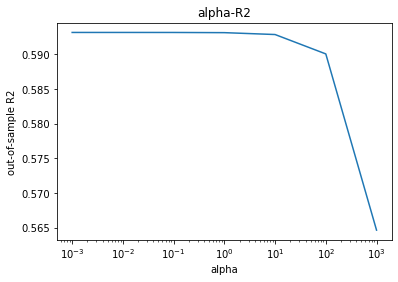

In [26]:
alphas = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
oosR2 = []

for alpha in alphas:
    temp_reg = Ridge(alpha=alpha).fit(caX_train, cay_train)
    oosR2.append(temp_reg.score(caX_test, cay_test))
    
plt.figure(1)
ax = plt.gca()
ax.plot(alphas, oosR2)
ax.set_xscale("log")
ax.set_xlabel('alpha')
ax.set_ylabel('out-of-sample R2')
ax.set_title('alpha-R2')
plt.show()

### LASSO回归

Lasso对回归系数施加了 $L_1$ 正则项, 这样虽然使得损失函数不可微, 但却使模型倾向于保留稀疏解, 相当于模型自动进行特征选择. sklearn用`Lasso`类创建实例, 其参数与`Ridge`类似. 同样地, 我们可以用搜索或者`LassoCV`来找到最佳超参数, 下面的结果表明依然不需要正则化.

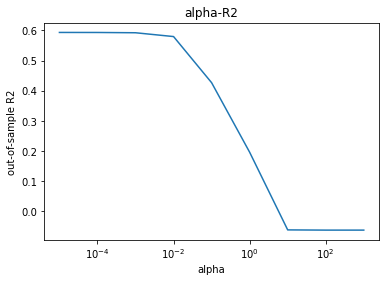

In [29]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
oosR2 = []

for alpha in alphas:
    temp_reg = Lasso(alpha=alpha).fit(caX_train, cay_train)
    oosR2.append(temp_reg.score(caX_test, cay_test))

plt.figure(1)
ax = plt.gca()
ax.plot(alphas, oosR2)
ax.set_xscale("log")
ax.set_xlabel('alpha')
ax.set_ylabel('out-of-sample R2')
ax.set_title('alpha-R2')
plt.show()

不过, Lasso的特征筛选能力在面临大量特征时很有用. 使用`lasso_path()`函数可以生成系数随着`alpha`变化的路径, 观察变量是如何被筛选的. 它除了接受待拟合的数据外, 还接收一系列`alpha`值, 可以通过以下参数传入系列`alpha`值.

- `eps`: 自动选择`alpha`值, 其中`eps = alpha_min / alpha_max`.
- `n_alphas`: 整数, 指定要尝试的`alpha`值的数量.
- `alphas`: 直接指定`alpha`值列表.

然后, `lasso_path`会返回

- `alphas`: 函数尝试的`alpha`值列表, 是形状为`(n_alphas,)`的数组.
- `coefs`: 每个`alpha`值对应的属性系数, 形状为`(n_features, n_alphas)`, 即每一行代表一个特征的系数路径.

还有其他的返回值, 但并不是我们所关心的, 如果要绘制系数路径, 只需使用

```python
alphas, coefs, _ = lasso_paths(X, y, *)
```

下图表示, 随着`alpha`值的增大, 模型系数逐渐衰减到 $0$.

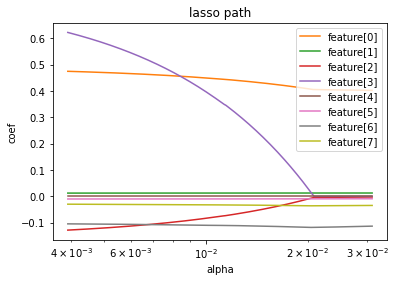

In [59]:
alphas = np.power(2, np.arange(-8, -5, 0.01))
alphas, coefs, _ = lasso_path(caX_train, cay_train, alphas=alphas, max_iter=1e5)
colors = ["C{}".format(str(i)) for i in range(1, coefs.shape[0] + 1)]

plt.figure(1)
ax = plt.gca()

for i in range(len(colors)):
    ax.plot(alphas, coefs[i], c=colors[i], label='feature[{}]'.format(str(i)))

ax.set_xscale("log")
ax.set_xlabel('alpha')
ax.set_ylabel('coef')
ax.set_title('lasso path')
ax.legend()
plt.show()

### Elastic Net

介绍完岭回归和Lasso, Elastic Net就不必多加赘述, 实际上它的损失函数是 $L_1$ 损失和 $L_2$ 损失的加权. 使用`ElasticNet`类创建实例, 分别用`alpha`和`l1_ratio`参数控制 $\alpha$ 和 $\rho$ 的大小, 再拟合数据, 就得到了Elastic Net模型. 对最优超参数的选择, 依然可以使用`ElasticNetCV`进行网格化搜索.

由于Elastic Net的损失函数中也包含 $L_1$ 正则, 因此可以用于特征筛选, 类似地`enet_path()`函数也提供了类似于`lasso_path()`的功能, 绘制模型系数随正则化参数变化的图, 不过在这一过程中, `l1_ratio`是不变的.

## 1.3 稳健线性回归

## 参考资料

\[1\] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html  
\[2\] https://scikit-learn.org/stable/modules/linear_model.html  
\[3\] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html  
\[4\] https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html  
\[5\] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html